<a href="https://colab.research.google.com/github/mxng2/traffic_prediction/blob/main/%EB%8F%84%EB%A1%9C_%EA%B5%90%ED%86%B5%EB%9F%89_%EB%B6%84%EC%84%9D_%EB%B0%8F_%EC%98%88%EC%B8%A1%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# shap 설치
%pip install shap

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/한경_토스뱅크_2024/01_Machine Learning/실습 프로젝트/도로 교통량 예측")
os.getcwd()

'/content/drive/MyDrive/한경_토스뱅크_2024/01_Machine Learning/실습 프로젝트/도로 교통량 예측'

In [ ]:
import pandas as pd
df = pd.read_csv('data/train.csv')
df.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


# 문제 정의
- 2022년 기준으로 제주도민 인구수가 68만명. 연 평균 1.3% 정도 매년 증가한다.

- 외국인과 관광객 까지 포함하면 제주도에 상주하는 인구가 90만명 가까이 된다고 합니다.

- 제주도민과 외국인, 관광객 증가로 인해 현재 제주도의 교통 체증이 매우 심각하다.

> **데이터 살펴보기**

* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|id|아이디|
|base_date|날짜|
|day_of_week|요일|
|base_hour|시간대|
|road_in_use|도로사용여부|
|lane_count|차로수|
|road_rating|도로등급|
|multi_linked|중용구간 여부|
|connect_code|연결로 코드|
|maximum_speed_limit|최고속도제한|
|weight_restricted|통과제한하중|
|height_restricted|통과제한높이|
|road_type|도로유형|
|start_latitude|시작지점의 위도|
|start_longitude|시작지점의 경도|
|start_turn_restricted|시작 지점의 회전제한 유무|
|end_latitude|도착지점의 위도|
|end_longitude|도착지점의 경도|
|end_turn_restricted|도작지점의 회전제한 유무|
|road_name|도로명|
|start_node_name|시작지점명|
|end_node_name|도착지점명|
|vehicle_restricted|통과제한차량|
|target|평균속도(km)|

In [ ]:
df.shape

(4701217, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

# 문제 해결 프로세스 정의
> 문제 정의

```
제주도는 매년 인구수와 관광객이 증가하여 교통량이 많이 늘어나고 있다.

제주도민들의 출퇴근 시간에 영향을 많이 미치는 영향 변수를 찾고, 개선

현재는 각 지도 관련 회사(카카오, 티맵, 네이버 등등)들이 데이터를 수집하여 길찾기 서비스를 제공중

나라에서 관리하고 있는 다양한 지표들이 교통량에 어떠한 영향을 미치는지 분석하고, 특정 시간대 통행량을 예상할 예정
결국 특정 시간대의 통행량을 예측하는 모델을 만들자
```

> 기대 효과
```
통행량 예측이 부적절하면 예를 들어 막히는 시간을 피해 운송 스케쥴 같은 것들( 택배나 레미콘 등등 )을 구성하는 사람들이 재산 피해를 볼 수도 있다.
관광객들도 여행 스케쥴을 짬에 있어서 피해를 볼 수도 있다.
```
```
통행량 예측이 정확하다면 급출발/급감속 구간 같은 것들이 줄어들기 때문에 유류비 절감 효과도 누릴 수 있나...?
```

> 해결 방안
```
수집된 데이터(사실은 공모전에서 받은 데이터)를 기반으로 모델링에 필요한 Feature를 추출한다. 추출된 데이터 중 좌표 데이터 기반으로 현재 데이터를 지도 상에 시각화 할 것이다.(활용)
```

> 성과 측정
- 공모전에서 제안된 경우도 있고, 우리가 직접 생각해야 하는 경우도 있다.
- 단순하게 생각하면 회귀는 LOSS, 분류는 ACC, PRE,RE,F1 등등

```
속도 예측 정확도(Mean Absolute Percentage)
```

In [ ]:
# 길의 이름 별로 평균 속도 확인
df.groupby("road_name")['target'].mean()

,target
road_name,
-,44.774556
경찰로,24.686785
고평교,36.126862
관광단지1로,39.292453
관광단지2로,34.469287
관광단지로,30.307276
관덕로,30.295770
권학로,26.800154
남조로,34.098048


In [ ]:
map_data = df.groupby(['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude'])['target'].mean()
map_data = map_data.reset_index()
map_data

,start_latitude,start_longitude,end_latitude,end_longitude,target
0,33.243432,126.422025,33.244882,126.419089,38.312229
1,33.244512,126.427069,33.249505,126.430787,40.656777
2,33.244601,126.562080,33.244871,126.564407,25.666780
3,33.244601,126.562080,33.247607,126.561943,26.480407
4,33.244871,126.564407,33.244601,126.562080,21.997473
...,...,...,...,...,...
899,33.553525,126.739714,33.554302,126.738379,39.010253
900,33.554302,126.738379,33.553525,126.739714,54.543224
901,33.554302,126.738379,33.555316,126.736681,42.734928
902,33.555316,126.736681,33.554302,126.738379,37.525066


In [ ]:
import folium

In [ ]:
map = folium.Map(location=[33.308412, 126.488029],zoom_start=10)

# 도로의 시작 위경도, 끝 위경도, 속도 정보를 받아서 지도에 뿌려줄 함수.
def to_line(x):
  # 속도에 따른 색 지정
  if x['target'] > 80: target_color="green"
  elif x['target'] > 50: target_color='blue'
  elif x['target'] > 30: target_color='orange'
  else: target_color='red'

  folium.PolyLine(
      locations=[[x['start_latitude'], x['start_longitude']], # 시작 지점 위경도
                 [x['end_latitude'], x['end_longitude']]], # 끝 지점 위경도
      color=target_color
  ).add_to(map)

map_data.apply(to_line, axis=1)
map

# 수집된 데이터의 기본 정보 확인
- 유사한 정보를 가진 데이터 컬럼 확인 및 제거
- 문자열 자료형 데이터를 날짜형 자료형으로 변환
- 실제 교통량에 영향을 미칠 것 같은 속성을 탐색

In [ ]:
# 숫자 형태의 컬럼과 문자열 형태의 컬럼 분리
import numpy as np

# select_dtypes : 자료형으로 컬럼을 선택
num_columns = df.select_dtypes(include=np.number).columns.tolist()
cat_columns = df.select_dtypes(include=object).columns.tolist()

num_columns, cat_columns

(['base_date',
  'base_hour',
  'lane_count',
  'road_rating',
  'multi_linked',
  'connect_code',
  'maximum_speed_limit',
  'vehicle_restricted',
  'weight_restricted',
  'height_restricted',
  'road_type',
  'start_latitude',
  'start_longitude',
  'end_latitude',
  'end_longitude',
  'target'],
 ['id',
  'day_of_week',
  'road_name',
  'start_node_name',
  'start_turn_restricted',
  'end_node_name',
  'end_turn_restricted'])

In [ ]:
# start_node_name, end_node_name은 해당 지역을 나타내는 위 경도 정보와 상관관계가 높다.
df[['road_name', 'start_node_name', 'end_node_name']].head()

,road_name,start_node_name,end_node_name
0,지방도1112호선,제3교래교,제3교래교
1,일반국도11호선,광양사거리,KAL사거리
2,일반국도16호선,창고천교,상창육교
3,태평로,남양리조트,서현주택
4,일반국도12호선,애월샷시,애월입구


In [ ]:
df[df['road_name'] == '-'].shape

(569463, 23)

In [ ]:
df['day_of_week'].head()

,day_of_week
0,목
1,목
2,일
3,금
4,화


In [ ]:
# id값은 머신러닝에 들어가서는 안되는 데이타
df[['id', 'day_of_week', 'road_name', 'start_node_name', 'end_node_name']]

,id,day_of_week,road_name,start_node_name,end_node_name
0,TRAIN_0000000,목,지방도1112호선,제3교래교,제3교래교
1,TRAIN_0000001,목,일반국도11호선,광양사거리,KAL사거리
2,TRAIN_0000002,일,일반국도16호선,창고천교,상창육교
3,TRAIN_0000003,금,태평로,남양리조트,서현주택
4,TRAIN_0000004,화,일반국도12호선,애월샷시,애월입구
...,...,...,...,...,...
4701212,TRAIN_4701212,목,-,대림사거리,금덕해운
4701213,TRAIN_4701213,목,-,광삼교,광삼교
4701214,TRAIN_4701214,월,일반국도12호선,고성교차로,성산교차로
4701215,TRAIN_4701215,수,일반국도95호선,제6광령교,관광대학입구


# 특성 공학


## 날짜 관련 데이터 추출
- 날짜 데이터 추출

In [ ]:
df['base_date'] = pd.to_datetime(df['base_date'], format="%Y%m%d")
df['year'] = df['base_date'].dt.year
df['month'] = df['base_date'].dt.month
df['dayofweek'] = df['base_date'].dt.dayofweek # 숫자 형식으로 요일을 뽑아냄

# 필요 없는 데이터 삭제
- id, day_of_week, road_name, start_node_name, end_node_name, base_date

In [ ]:
df = df.drop(['id', 'base_date', 'day_of_week', 'road_name', 'start_node_name', 'end_node_name', 'base_date'], axis=1)
df

,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,target,year,month,dayofweek
0,17,1,106,0,0,60.0,0.0,32400.0,0.0,3,33.427747,126.662612,없음,33.427749,126.662335,없음,52.0,2022,6,3
1,21,2,103,0,0,60.0,0.0,0.0,0.0,0,33.500730,126.529107,있음,33.504811,126.526240,없음,30.0,2022,7,3
2,7,2,103,0,0,80.0,0.0,0.0,0.0,0,33.279145,126.368598,없음,33.280072,126.362147,없음,61.0,2021,10,6
3,13,2,107,0,0,50.0,0.0,0.0,0.0,0,33.246081,126.567204,없음,33.245565,126.566228,없음,20.0,2022,3,4
4,8,2,103,0,0,80.0,0.0,0.0,0.0,0,33.462214,126.326551,없음,33.462677,126.330152,없음,38.0,2021,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,16,1,107,0,0,50.0,0.0,0.0,0.0,0,33.422145,126.278125,없음,33.420955,126.273750,없음,20.0,2021,11,3
4701213,2,2,107,0,0,80.0,0.0,43200.0,0.0,3,33.472505,126.424368,없음,33.472525,126.424890,없음,65.0,2022,3,3
4701214,22,2,103,0,0,60.0,0.0,0.0,0.0,0,33.447183,126.912579,없음,33.444121,126.912948,없음,30.0,2022,6,0
4701215,2,2,103,0,0,80.0,0.0,0.0,0.0,0,33.443596,126.431817,없음,33.444996,126.433332,없음,73.0,2021,10,2


In [ ]:
df.loc[df['start_turn_restricted'] == '없음', 'start_turn_restricted'] = 0
df.loc[df['start_turn_restricted'] == '있음', 'start_turn_restricted'] = 1

df.loc[df['end_turn_restricted'] == '없음', 'end_turn_restricted'] = 0
df.loc[df['end_turn_restricted'] == '있음', 'end_turn_restricted'] = 1

# 타입 강제 변경
df['start_turn_restricted'] = df['start_turn_restricted'].astype(int)
df['end_turn_restricted'] = df['end_turn_restricted'].astype(int)

df

,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,target,year,month,dayofweek
0,17,1,106,0,0,60.0,0.0,32400.0,0.0,3,33.427747,126.662612,0,33.427749,126.662335,0,52.0,2022,6,3
1,21,2,103,0,0,60.0,0.0,0.0,0.0,0,33.500730,126.529107,1,33.504811,126.526240,0,30.0,2022,7,3
2,7,2,103,0,0,80.0,0.0,0.0,0.0,0,33.279145,126.368598,0,33.280072,126.362147,0,61.0,2021,10,6
3,13,2,107,0,0,50.0,0.0,0.0,0.0,0,33.246081,126.567204,0,33.245565,126.566228,0,20.0,2022,3,4
4,8,2,103,0,0,80.0,0.0,0.0,0.0,0,33.462214,126.326551,0,33.462677,126.330152,0,38.0,2021,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,16,1,107,0,0,50.0,0.0,0.0,0.0,0,33.422145,126.278125,0,33.420955,126.273750,0,20.0,2021,11,3
4701213,2,2,107,0,0,80.0,0.0,43200.0,0.0,3,33.472505,126.424368,0,33.472525,126.424890,0,65.0,2022,3,3
4701214,22,2,103,0,0,60.0,0.0,0.0,0.0,0,33.447183,126.912579,0,33.444121,126.912948,0,30.0,2022,6,0
4701215,2,2,103,0,0,80.0,0.0,0.0,0.0,0,33.443596,126.431817,0,33.444996,126.433332,0,73.0,2021,10,2


In [ ]:
# 모든 데이터가 숫자 타입인 것을 확인
df.dtypes

,0
base_hour,int64
lane_count,int64
road_rating,int64
multi_linked,int64
connect_code,int64
maximum_speed_limit,float64
vehicle_restricted,float64
weight_restricted,float64
height_restricted,float64
road_type,int64


# Feature Selection
- 어떤 Feature가 Target에 영향을 많이 미치는지
- 상관 관계 분석
  - 연속형 변수에 대한 상관성만 확인을 해야한다.
- SHAP
  - 모델을 만들어서 어떤 변수가 타겟에 영향을 많이 미치는지를 분석

In [ ]:
# Feature와 Target 분리
X = df.drop("target", axis=1)
y = df['target']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # 구간 내에서 "평균"을 사용하는 방식

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0
)

In [ ]:
# StandardScaling 적용
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

In [ ]:
rf_clf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5, # 과대적합 트리를 사용하지 않음! 깊이를 최대로 설정하면 훈련하는데 3시간 걸려요...
    n_jobs=-1,
    verbose=1,
    random_state=0
)

rf_clf.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished


RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=0, verbose=1)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

predicted_train = rf_clf.predict(X_train_scaled)
predicted_test = rf_clf.predict(X_test_scaled)

print(f"{mean_absolute_percentage_error(predicted_train, y_train)}")
print(f"{mean_absolute_percentage_error(predicted_test, y_test)}")

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.2s


0.20098176370201384
0.20100248133479878


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.9s finished


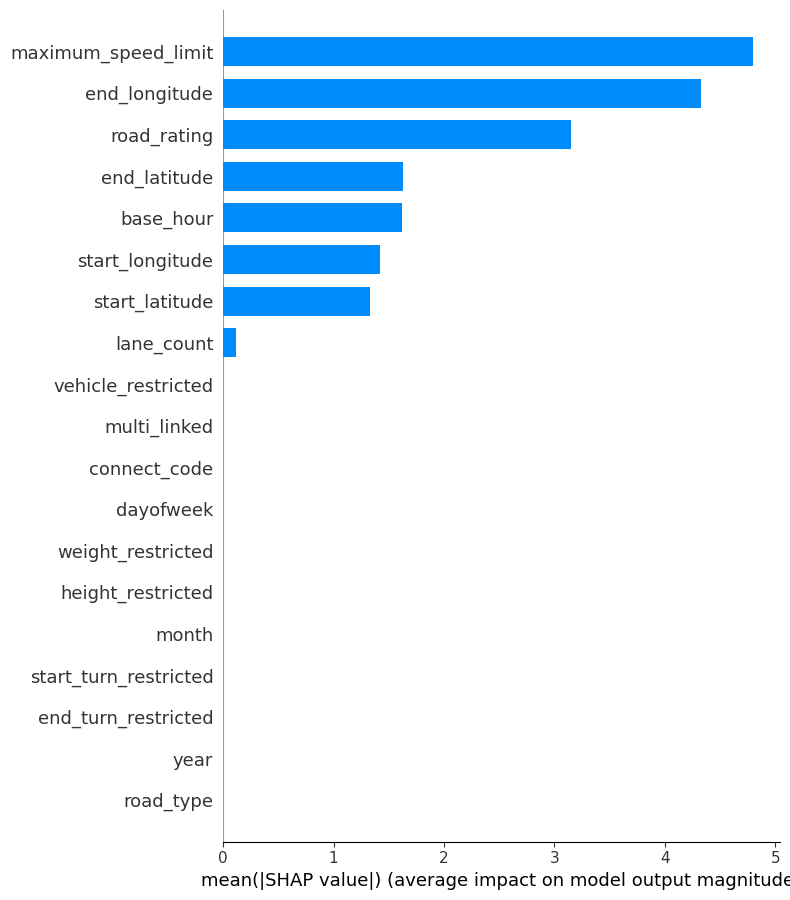

In [ ]:
import shap

explainer = shap.Explainer(rf_clf)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test, plot_type='bar') # permutation importance

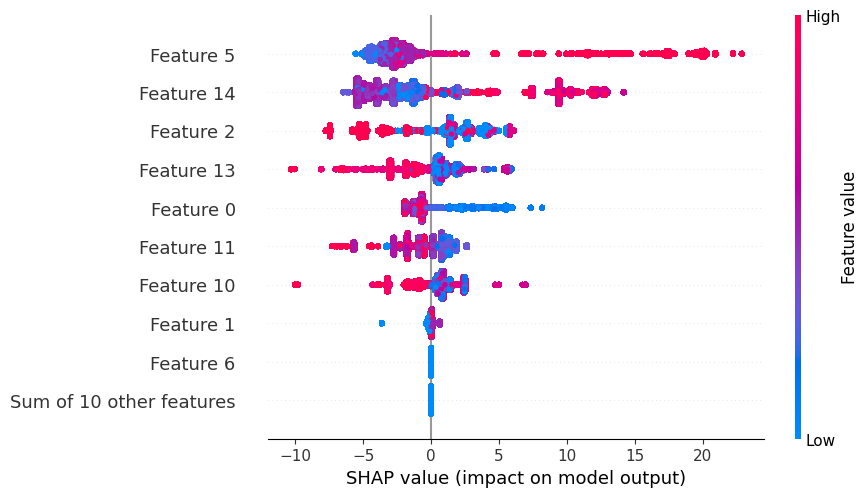

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
# SHAP 분석을 통해 의미가 있는 Feature만 따로 뽑아서 훈련
X_train, X_test, y_train, y_test = train_test_split(
    X[['maximum_speed_limit','end_latitude','start_latitude','road_rating','start_longitude','base_hour','end_longitude','lane_count']],
    y,
    test_size=0.2,
    random_state=0
)

In [ ]:
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std  = sc.transform(X_test)

rf_reg = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1, verbose=1, random_state=0)

rf_reg.fit(X_train_std, y_train)

predicted_train = rf_reg.predict(X_train_std)
predicted_test = rf_reg.predict(X_test_std)

print(f"{mean_absolute_percentage_error(predicted_train, y_train)}")
print(f"{mean_absolute_percentage_error(predicted_test, y_test)}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s


0.20098176370201384
0.20100248133479878


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.8s finished


In [ ]:
explainer = shap.Explainer(rf_clf)
shap_values = explainer(X_test_std)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
# XGBoost
import xgboost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgb_model = xgboost.XGBRegressor(n_estimators=100, max_depth=5)
xgb_model.fit(X_train, y_train)

xgb_predicted_train = xgb_model.predict(X_train)
xgb_predicted_test = xgb_model.predict(X_test)

print(f"{mean_absolute_percentage_error(xgb_predicted_train, y_train)}")
print(f"{mean_absolute_percentage_error(xgb_predicted_test, y_test)}")

In [ ]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
shap.plots.beeswarm(shap_values)

- 훈련 세트 정확도 : 0.11365148858422532
- 테스트 세트 정확도 : 0.11370190970056993